In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import utils
from torch.utils.data import DataLoader

from Flow1D import Flow1D
from dataset import GaussianMixtureDataset
from plot import plot_results_flow_1D

In [2]:
# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [3]:
# Hyperparameters
NUM_EPOCHS = 500
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

**Generating the synthetic dataset**

The true (unknown) data distribution is a mixture of 2 gaussians.

In [4]:
# Data distribution:
means = torch.tensor([-1, 3], dtype=torch.float32)
standard_deviations = torch.tensor([0.5, 1], dtype=torch.float32)
mix_coefs = torch.tensor([0.5, 0.5])

# Generating the dataset
dataset = GaussianMixtureDataset(mix_coefs, means, standard_deviations, num_samples=1024)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

**Creating a model**

Model transforms the data distribution (unknown) to Beta(2, 2) distribution.

In [5]:
# Model
alpha = 2
beta = 2
model = Flow1D(num_mixture_components=5, alpha=alpha, beta=beta).to(device)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

Visualizing model's performance before training

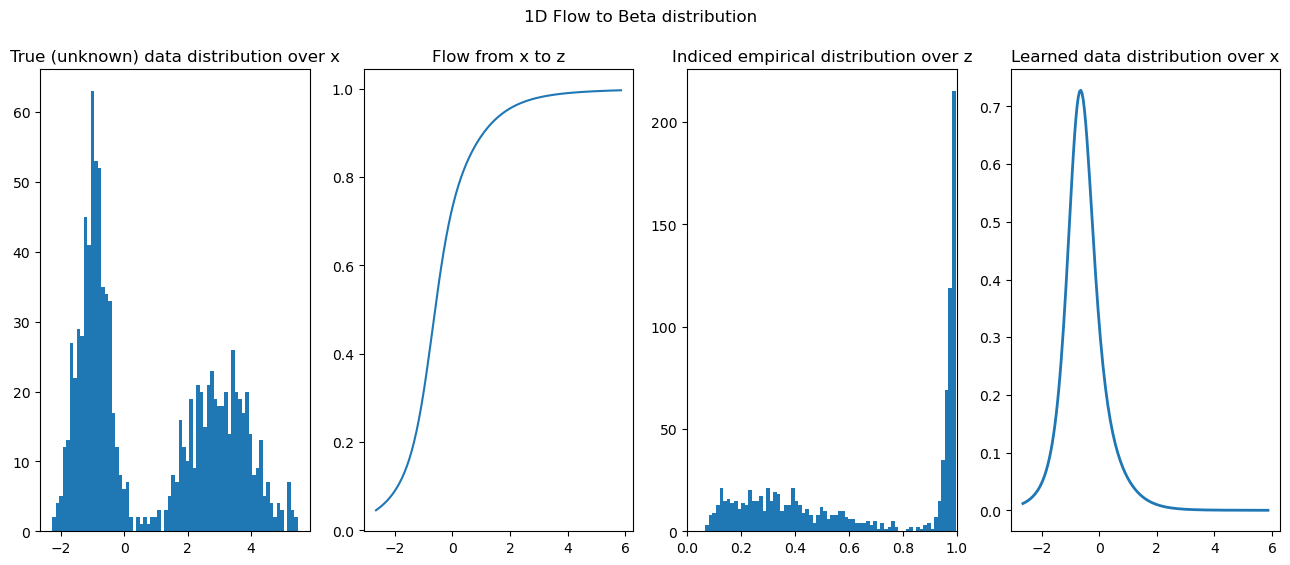

In [6]:
# Data gymnastics
data = dataset.data.to(device)
transformed_data = model(dataset.data.to(device))
plot_results_flow_1D(data, transformed_data, model, device)

**Training the model**

In [7]:
losses = []

In [8]:
# Training
for epoch in range(NUM_EPOCHS):
    avg_loss = []
    for batch_idx, data_points in enumerate(data_loader):
        # Data gymnastics
        data_points = data_points.to(device)

        # Loss
        loss = model.get_loss(data_points)
        avg_loss.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Making an update
        optimizer.step()

    avg_loss = torch.mean(torch.tensor(avg_loss))
    if epoch % 10 == 0:
        print('Epoch %d\t Loss=%.5f' % (epoch, avg_loss))
    losses.append(avg_loss)

Epoch 0	 Loss=5.22715
Epoch 10	 Loss=4.96479
Epoch 20	 Loss=4.74049
Epoch 30	 Loss=4.55030
Epoch 40	 Loss=4.39312
Epoch 50	 Loss=4.26636
Epoch 60	 Loss=4.16578
Epoch 70	 Loss=4.08656
Epoch 80	 Loss=4.02414
Epoch 90	 Loss=3.97471
Epoch 100	 Loss=3.93523
Epoch 110	 Loss=3.90336
Epoch 120	 Loss=3.87729
Epoch 130	 Loss=3.85560
Epoch 140	 Loss=3.83721
Epoch 150	 Loss=3.82124
Epoch 160	 Loss=3.80701
Epoch 170	 Loss=3.79395
Epoch 180	 Loss=3.78156
Epoch 190	 Loss=3.76939
Epoch 200	 Loss=3.75701
Epoch 210	 Loss=3.74395
Epoch 220	 Loss=3.72978
Epoch 230	 Loss=3.71401
Epoch 240	 Loss=3.69603
Epoch 250	 Loss=3.67496
Epoch 260	 Loss=3.64973
Epoch 270	 Loss=3.62030
Epoch 280	 Loss=3.58989
Epoch 290	 Loss=3.56414
Epoch 300	 Loss=3.54632
Epoch 310	 Loss=3.53550
Epoch 320	 Loss=3.52910
Epoch 330	 Loss=3.52499
Epoch 340	 Loss=3.52202
Epoch 350	 Loss=3.51964
Epoch 360	 Loss=3.51761
Epoch 370	 Loss=3.51584
Epoch 380	 Loss=3.51426
Epoch 390	 Loss=3.51284
Epoch 400	 Loss=3.51156
Epoch 410	 Loss=3.51040
Epo

Visualizing model's performance after training

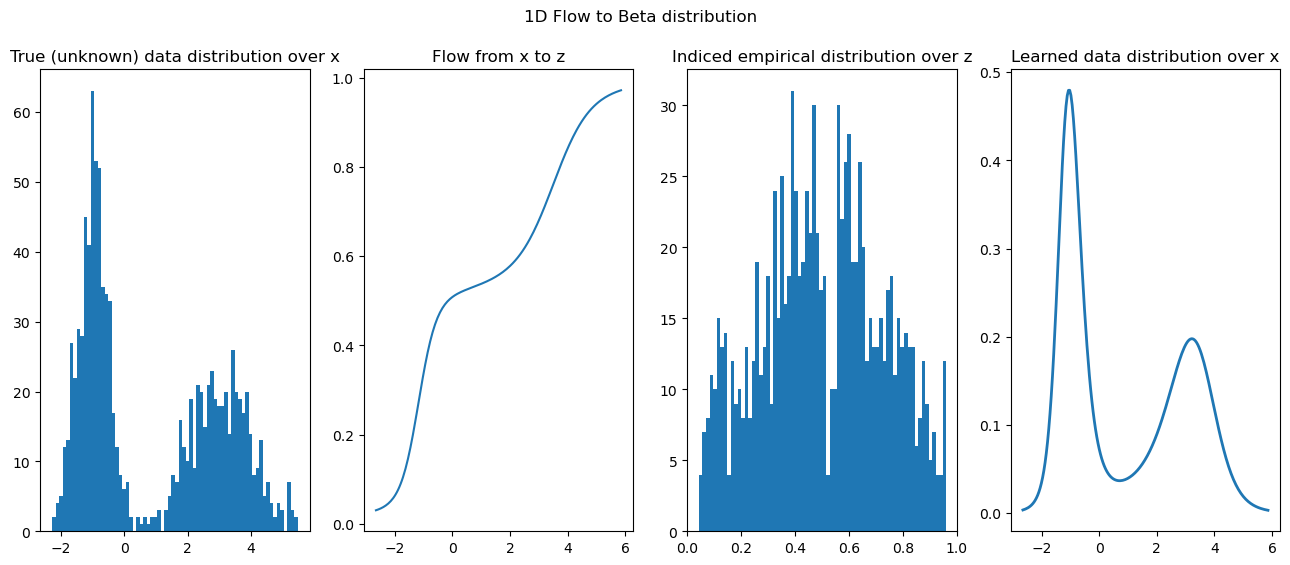

In [9]:
data = dataset.data.to(device)
transformed_data = model(dataset.data.to(device))

plot_results_flow_1D(data, transformed_data, model, device)

In [15]:
# Saving the model
torch.save(model, f'./weights/epoch_{NUM_EPOCHS}_FLOW1D.pth')